## Packages

In [5]:
# Install deprecated versions of numpy and spacy for package dependencies
!pip install numpy==1.26.4 > out
!pip install spacy==3.7.0 > out

#Package Bio scrapes pubmed.gov
!pip install biopython > out

# sumy required for abstract summarization
!pip install sumy > out

# for group names and summaries
!pip install transformers > out

!pip install tf-keras --user > out

!pip install bertopic > out


!pip install spacy > out
!python -m spacy download en_core_web_lg > out

!pip install selenium > out
!pip install bs4 > out


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-lg 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.7.0 which is incompatible.


In [6]:
# to scrape pubmed
from Bio import Entrez
import pandas as pd
from collections import Counter

# for the abstract summarization
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

# for plotting purposes and K-means
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# used for creating descriptions of they key word cluster
from transformers import pipeline

# For preprocessing and lemmitization of Abstracts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
import nltk

# For LDA grouping
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE


# Download the required NLTK resources
nltk.download('punkt')

import spacy
spacy.load('en_core_web_lg')


# for BERTtopic
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer

Entrez.email = "jake.beckman@westpoint.edu"

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Functions

In [7]:
def search_pubmed(query, max_results=20000, start_date=None, review_papers_only = False):
    """
    Perform a search on PubMed using the given query and return the results, with a fixed end date and a variable start date.
    
    :param query: The search query string.
    :param max_results: The maximum number of results to retrieve.
    :param start_date: The earliest publication date to include (YYYY/MM/DD format), default is None.
    :param review_papers_only: Boolean value that picks if the query will only scrape for review papers default is False
    :return: The search results in XML format.
    """
    # Set the fixed end date
    end_date = "2024/09/10" # for reproducibilty, we use a fixed end date, but in pracitce, this should be today's date

    # If a start_date is provided, modify the query to include the date range
    if start_date:
        query += f" AND ({start_date}[Date - Publication] : {end_date}[Date - Publication])"
    else:
        query += f" AND ( 0000/01/01[Date - Publication] : {end_date}[Date - Publication])"

    # Modify query to only pick up review papers
    if review_papers_only:
        query += f" AND (review[pt])"
        
    # Use the esearch utility to search PubMed
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results, usehistory='y')
    # Read the search results
    record = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()

    # Print the total number of articles found on PubMed for this query
    total_articles = int(record["Count"])
    print(f"Query: {query}")
    print(f"Total articles found for the query: {total_articles}")
    
    # Extract the list of PubMed IDs (PMIDs) from the search results
    id_list = record["IdList"]
    
    # Use the efetch utility to fetch details for each PMID
    handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
    # Read the fetched records
    records = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()
    
    return records

In [8]:
import os
path = "/home/jovyan/PythonVirtualEnvironment/msedgedriver"  # Replace with the path you want to check

if os.path.exists(path):
    print(f"The path '{path}' exists.")
else:
    print(f"The path '{path}' does not exist.")



The path '/home/jovyan/PythonVirtualEnvironment/msedgedriver' exists.


In [9]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service as EdgeService
from selenium.webdriver.edge.options import Options

edge_options = Options()
edge_options.binary_location = "C:\Program Files (x86)\Microsoft\Edge\Application" # Adjust to the Edge browser path if necessary

edge_service = EdgeService(executable_path="/home/jovyan/PythonVirtualEnvironment/msedgedriver")
driver = webdriver.Edge(service=edge_service, options=edge_options)

driver.get("https://www.embase.com")


SessionNotCreatedException: Message: session not created
from unknown error: no msedge binary at C:\Program Files (x86)\Microsoft\Edge\Application
Stacktrace:
#0 0x57c4434895be <unknown>
#1 0x57c442f509f6 <unknown>
#2 0x57c442f856a7 <unknown>
#3 0x57c442f825d9 <unknown>
#4 0x57c442fcd0c2 <unknown>
#5 0x57c442fcc30f <unknown>
#6 0x57c442fbfcf3 <unknown>
#7 0x57c442f902de <unknown>
#8 0x57c442f90fbe <unknown>
#9 0x57c44345e521 <unknown>
#10 0x57c443461791 <unknown>
#11 0x57c44346120b <unknown>
#12 0x57c443461bc5 <unknown>
#13 0x57c44344fef2 <unknown>
#14 0x57c443461f4d <unknown>
#15 0x57c4434398c5 <unknown>
#16 0x57c443479d18 <unknown>
#17 0x57c443479f2f <unknown>
#18 0x57c4434881bc <unknown>
#19 0x7c83a33c9ac3 <unknown>


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import pandas as pd
import time

def search_embase(query, username, password = "MaYM5t42-yp9h9_"):
    """
    Searches Embase for a given query and returns a DataFrame of articles.
    
    :param query: Search query for Embase.
    :param username: Embase login username.
    :param password: Embase login password.
    :return: DataFrame containing article information.
    """
    
    # Initialize WebDriver
    driver = webdriver.Chrome()  # Ensure ChromeDriver is in PATH or specify path to the driver
    driver.get("https://www.embase.com")
    
    # Log in to Embase (Adjust element names if needed)
    driver.find_element(By.ID, "username").send_keys(username)
    driver.find_element(By.ID, "password").send_keys(password)
    driver.find_element(By.ID, "login-button").click()
    time.sleep(3)  # Wait for login to complete
    
    # Input the query into the search box
    search_box = driver.find_element(By.ID, "search-box")
    search_box.send_keys(query)
    search_box.send_keys(Keys.RETURN)
    time.sleep(5)  # Wait for search results to load
    
    # Retrieve articles by parsing HTML
    articles = []
    while True:
        soup = BeautifulSoup(driver.page_source, "html.parser")
        
        # Locate articles in the HTML
        results = soup.find_all("div", class_="result-item")  # Adjust as per Embase's structure
        
        for item in results:
            title = item.find("h3", class_="title").get_text(strip=True)
            authors = item.find("span", class_="authors").get_text(strip=True)
            abstract = item.find("div", class_="abstract").get_text(strip=True)
            url = item.find("a", class_="link")["href"]
            articles.append({"Title": title, "Authors": authors, "Abstract": abstract, "URL": url})
        
        # Check for 'Next' button and click it, or break loop if not found
        try:
            next_button = driver.find_element(By.LINK_TEXT, "Next")
            next_button.click()
            time.sleep(3)  # Wait for next page to load
        except:
            break  # Exit loop if no next button is found
    
    # Close the WebDriver
    driver.quit()
    
    # Convert results to DataFrame
    articles_df = pd.DataFrame(articles)
    return articles_df

# Usage example
username = "jake.beckman@westpoint.edu"
password = "MaYM5t42-yp9h9_"
df = search_embase("diabetes AND exercise", username, password)


### Scraping

In [10]:
def search_pubmed(query, max_results=20000, start_date=None, review_papers_only = False):
    """
    Perform a search on PubMed using the given query and return the results, with a fixed end date and a variable start date.
    
    :param query: The search query string.
    :param max_results: The maximum number of results to retrieve.
    :param start_date: The earliest publication date to include (YYYY/MM/DD format), default is None.
    :param review_papers_only: Boolean value that picks if the query will only scrape for review papers default is False
    :return: The search results in XML format.
    """
    # Set the fixed end date
    end_date = "2024/09/10" # for reproducibilty, we use a fixed end date, but in pracitce, this should be today's date

    # If a start_date is provided, modify the query to include the date range
    if start_date:
        query += f" AND ({start_date}[Date - Publication] : {end_date}[Date - Publication])"
    else:
        query += f" AND ( 0000/01/01[Date - Publication] : {end_date}[Date - Publication])"

    # Modify query to only pick up review papers
    if review_papers_only:
        query += f" AND (review[pt])"
        
    # Use the esearch utility to search PubMed
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results, usehistory='y')
    # Read the search results
    record = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()

    # Print the total number of articles found on PubMed for this query
    total_articles = int(record["Count"])
    print(f"Query: {query}")
    print(f"Total articles found for the query: {total_articles}")
    
    # Extract the list of PubMed IDs (PMIDs) from the search results
    id_list = record["IdList"]
    
    # Use the efetch utility to fetch details for each PMID
    handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
    # Read the fetched records
    records = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()
    
    return records

In [11]:
# Summarize the abstract of the article
def summarize_abstract(abstract):
    """
    Summarize the abstract into 1-2 sentences using LSA summarization.
    
    :param abstract: The abstract of the article.
    :return: A summary of the abstract.
    """
    if not abstract:
        return ""
    
    parser = PlaintextParser.from_string(abstract, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, 2)  # Summarize to 2 sentences
    
    return " ".join(str(sentence) for sentence in summary)


In [12]:
def extract_article_info(records):
    """
    Extract core article information from PubMed records, including title, authors, abstract, PubMed ID, URL, references, publication date, and journal.
    
    :param records: The PubMed records in XML format.
    :return: A DataFrame containing the extracted information.
    """
    data = []
    
    for article in records["PubmedArticle"]:
        # Extract authors and concatenate their names, if available
        authors_list = []
        if "AuthorList" in article["MedlineCitation"]["Article"]:
            for author in article["MedlineCitation"]["Article"]["AuthorList"]:
                last_name = author.get("LastName", "")
                fore_name = author.get("ForeName", "")
                authors_list.append(last_name + " " + fore_name)
            authors = ", ".join(authors_list)
        else:
            authors = ""
        
        # Extract the article title
        title = article["MedlineCitation"]["Article"]["ArticleTitle"]
        
        # Extract the article abstract (or use an empty string if not available)
        abstract = article["MedlineCitation"]["Article"].get("Abstract", {}).get("AbstractText", [""])[0]
        
        # Extract the PubMed ID
        pubmed_id = article["MedlineCitation"]["PMID"]
        
        # Construct the PubMed URL
        url = f"https://pubmed.ncbi.nlm.nih.gov/{pubmed_id}/"

        # Extract the journal name
        journal = article["MedlineCitation"]["Article"].get("Journal", {})
        journal_name = journal.get("Title", "")
        
        # Extract publication date
        pub_date = ""
        
        if "PubDate" in journal:
            pub_date_obj = journal["PubDate"]
            year = pub_date_obj.get("Year", "")
            month = pub_date_obj.get("Month", "")
            day = pub_date_obj.get("Day", "")
            pub_date = f"{year}-{month}-{day}".strip("-")
        elif "MedlineDate" in journal.get("PubDate", {}):
            pub_date = journal["PubDate"]["MedlineDate"]

        # Summarize the abstract 
        summary = summarize_abstract(abstract)

        # Append the extracted data
        data.append({
            "Authors": authors,
            "Title": title,
            "Abstract": abstract,
            "Summary": summary,
            "PublicationDate": pub_date,
            "PubMedURL": url,
            "Journal": journal_name 
        })
    
    # Convert the list of dictionaries to a DataFrame for easier handling
    return pd.DataFrame(data)


### Sorting functions

In [13]:
# Preprocessing
def tokenize_and_lemmatize(df):
    """
    Processes a DataFrame by lemmatizing and tokenizing the 'Preprocessed_Abstract' column and 
    returns the DataFrame with an updated column containing the processed text.
    
    :param df: DataFrame with a 'Preprocessed_Abstract' column.
    :return: DataFrame with a modified 'Preprocessed_Abstract' column containing lemmatized text.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get the default English stopwords from spacy
    nlp = spacy.load('en_core_web_lg')
    stop_words = nlp.Defaults.stop_words
    
    # Function to preprocess, tokenize, and lemmatize text
    def preprocess(text):
        tokens = text.split()
        return ' '.join([lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words])

    # Apply the preprocessing and tokenization function
    df['Preprocessed_Abstract'] = df['Abstract'].fillna('').apply(lambda text: preprocess(text))

    # Remove custom stopwords using regular expressions 
    df['Preprocessed_Abstract'] = df['Preprocessed_Abstract'].replace(r'\bsup\b|\bsub\b|\bsp\b|\bwa\b', '', regex=True)
    df['Preprocessed_Abstract'] = df['Preprocessed_Abstract'].replace(r'\balso\b|\bhowever\b|\bmay\b|\busing\b', '', regex=True)

    return df


In [14]:
# K-means method

def cluster_and_filter_relevance(df, n_clusters=5, n_key_words=10):
    """
    Perform K-means clustering on the articles' abstracts and filter the most relevant clusters with lemmatization.
    USes TF-IDF to vectorize the documents and K-means to cluster them into groups
    
    :param df: DataFrame containing the articles data.
    :param n_clusters: Number of clusters to create.
    :param n_key_words: Number of top keywords to use for filtering relevant clusters.
    
    :return: Filtered DataFrame with relevant clusters, and a dictionary containing cluster keywords.
    """
    # Vectorize the text data
    # max_df: if a word is contianed in 95% of documents it is discarded
    # min_df: if a word is only contained in 2 or less documents it is discarded
    vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')
    X = vectorizer.fit_transform(df['Preprocessed_Abstract'].fillna(''))

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    df['Cluster'] = kmeans.labels_
    
    # Analyze the clusters to determine relevance
    # Initialize a dictionary to store the keywords for each cluster
    cluster_keywords = {}
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    # Iterate through each cluster and store the top n keywords
    for i in range(n_clusters):
        cluster_keywords[i] = [terms[ind] for ind in order_centroids[i, :n_key_words]]
    
    # Here you could filter clusters based on relevance, or simply drop the combined column
    df_filtered = df.copy()  # If you want to perform further filtering, modify df_filtered

    # Return both the filtered DataFrame and the cluster_keywords dictionary
    return df_filtered, cluster_keywords



In [15]:
# LDA
def lda_topic_analysis(df, num_topics=5, num_top_words=10):
    """
    Performs LDA topic analysis on the 'Title' and 'Abstract' columns of the given DataFrame, 
    reduces dimensionality using t-SNE, and visualizes the topics in 2D space.

    :param df: DataFrame with 'Title' and 'Abstract' columns.
    :param num_topics: The number of topics to extract (default is 5).
    :param num_top_words: The number of top words to display for each topic (default is 10).
    :return: LDA model, document topic distribution, and t-SNE transformed data.
    """
    # Combine the text from the 'Title' and 'Abstract' columns
    text_data = df['Preprocessed_Abstract']

    # Use CountVectorizer to convert the text data into a matrix of token counts
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_data)

    # Define the LDA model with the number of topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    # Get the topic distribution for each document
    doc_topic_dist = lda.transform(X)

    # Reduce the dimensionality of the topics for visualization using t-SNE
    tsne_model = TSNE(n_components=2, random_state=42)
    tsne_lda = tsne_model.fit_transform(doc_topic_dist)

    # Plot the topics in a 2D space
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=doc_topic_dist.argmax(axis=1), cmap='viridis')
    plt.colorbar(label='Topic')
    plt.title('2D Visualization of LDA Topics')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

    # Display the top words in each topic
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

    df['LDA Cluster'] = doc_topic_dist.argmax(axis=1)
    
    return df, lda, doc_topic_dist, tsne_lda


In [16]:
def bert_topic_analysis(df):
    """
    Performs BERTopic analysis on the 'Preprocessed_Abstract' column using a medical language model for embeddings.
    
    :param df: DataFrame with a 'Preprocessed_Abstract' column.
    :return: BERTopic model and topics.
    """
    # Ensure text data is lemmatized and preprocessed
    docs = df['Preprocessed_Abstract'].tolist()
    
    # Load the Bio_ClinicalBERT model and wrap it for sentence-transformers compatibility
    model_name = "emilyalsentzer/Bio_ClinicalBERT"
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
    embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # Initialize BERTopic with the medical embedding model
    topic_model = BERTopic(embedding_model=embedding_model)

    # Fit the model and transform the documents into topics
    topics, probs = topic_model.fit_transform(docs)
    
    # Show the extracted topics
    print(topic_model.get_topic_info())
    
    # Visualize topics
    topic_model.visualize_topics()

    # Add Clusters to df
    df['BERT Cluster'] = topics

    return topic_model, topics, probs


### Summarization

In [18]:
def summarize_nltk(text, max_chars=500):
    """
    Summarize text using nltk by selecting sentences up to a character limit.
    
    :param text: Text to summarize.
    :param max_chars: Maximum character length for the summary.
    :return: Summary of the text within max_chars.
    """
    sentences = sent_tokenize(text)
    summary = ""
    
    for sentence in sentences:
        if len(summary) + len(sentence) <= max_chars:
            summary += sentence + " "
        else:
            break
            
    return summary.strip()


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### cluster similarities

In [39]:
def combine_abstracts(dataframe, cluster_label, cluster_col_title):
    """
    Combine abstracts of a specific cluster into a single text.
    
    :param dataframe: DataFrame containing article abstracts and cluster labels.
    :param cluster_label: The label of the cluster to combine abstracts for.
    :param cluster_col_title: The column name indicating the cluster labels.
    :return: Combined text of abstracts.
    """
    # Filter the DataFrame to the specific cluster and get the 'Preprocessed_Abstract' column
    abstracts = dataframe[dataframe[cluster_col_title] == cluster_label]['Preprocessed_Abstract']
    
    # Combine abstracts into a single text string
    combined_text = " ".join(abstracts.dropna().tolist())
    
    return combined_text


## Application

### Query and Initial Scrape and Grouping

In [100]:
query = '("genes" OR "genetics" OR "GWAS" OR "genomic" OR "hereditary") AND ("exercise" OR "physical activity" OR "fitness" OR "training" OR "aerobic")'
max_results = 100000  # Adjust the number of results to retrieve as needed
n_key_words = 10     # Adjust number of key words you want
n_clusters = 5       # Adjust number of clusters you want for the k-means clustering algorithm


In [101]:
# ONLY REVIEW PAPERS

# Perform the search and retrieve the records
records_review = search_pubmed(query, max_results, review_papers_only = True)

# Parse the retrieved records to extract the desired information
articles_data_review = pd.DataFrame(extract_article_info(records_review))

# Tokenize and Lemmitize the title and abstract and add it to a new col
articles_data_review = tokenize_and_lemmatize(articles_data_review)

# Perform k-nearest cluster on the data to group the articles into different groups.
articles_data_review, clusters_review = cluster_and_filter_relevance(articles_data_review, n_clusters = n_clusters, n_key_words = n_key_words)

for group in sorted(clusters_review.keys()):
    print(f'cluster {group} keywords: {clusters_review[group]}')

print("\nCluster counts:")
print(articles_data_review['Cluster'].value_counts().sort_index())

Query: ("genes" OR "genetics" OR "GWAS" OR "genomic" OR "hereditary") AND ("exercise" OR "physical activity" OR "fitness" OR "training" OR "aerobic") AND ( 0000/01/01[Date - Publication] : 2024/09/10[Date - Publication]) AND (review[pt])
Total articles found for the query: 11722
cluster 0 keywords: ['fitness', 'plant', 'host', 'evolution', 'resistance', 'selection', 'genetic', 'evolutionary', 'gene', 'population']
cluster 1 keywords: ['muscle', 'skeletal', 'exercise', 'mitochondrial', 'protein', 'sarcopenia', 'metabolic', 'expression', 'insulin', 'mass']
cluster 2 keywords: ['disease', 'obesity', 'risk', 'exercise', 'genetic', 'clinical', 'patient', 'study', 'health', 'physical']
cluster 3 keywords: ['cancer', 'tumor', 'cell', 'breast', 'glycolysis', 'metabolism', 'metabolic', 'cells', 'warburg', 'aerobic']
cluster 4 keywords: ['cell', 'mitochondrial', 'protein', 'stress', 'cellular', 'role', 'function', 'gene', 'mechanism', 'dna']

Cluster counts:
Cluster
0    2668
1     486
2    4030

In [102]:
#Non-Review papers

# Perform the search and retrieve the records
records = search_pubmed(query, max_results)

# Parse the retrieved records to extract the desired information
articles_data = pd.DataFrame(extract_article_info(records))

#remove overlapping articles, so this is just non-review papers
overlap = pd.merge(articles_data_review, articles_data, on='Title')
articles_data = articles_data[~articles_data['Title'].isin(overlap['Title'])]

# Tokenize and Lemmitize the title and abstract and add it to a new col
articles_data = tokenize_and_lemmatize(articles_data)

# Perform k-nearest cluster on the data to group the articles into different groups.
articles_data, clusters = cluster_and_filter_relevance(articles_data, n_clusters = n_clusters, n_key_words = n_key_words)

for group in sorted(clusters.keys()):
    print(f'cluster {group} keywords: {clusters[group]}')

print("\nCluster counts:")
print(articles_data['Cluster'].value_counts().sort_index())

Query: ("genes" OR "genetics" OR "GWAS" OR "genomic" OR "hereditary") AND ("exercise" OR "physical activity" OR "fitness" OR "training" OR "aerobic") AND ( 0000/01/01[Date - Publication] : 2024/09/10[Date - Publication])
Total articles found for the query: 115107
cluster 0 keywords: ['disease', 'study', 'patient', 'risk', 'genetic', 'clinical', 'association', 'associated', 'health', 'physical']
cluster 1 keywords: ['cancer', 'tumor', 'prognostic', 'cell', 'risk', 'prognosis', 'patient', 'immune', 'gene', 'model']
cluster 2 keywords: ['cell', 'muscle', 'exercise', 'expression', 'mouse', 'gene', 'protein', 'mitochondrial', 'skeletal', 'effect']
cluster 3 keywords: ['strain', '16', 'genus', 'dna', 'nov', 'rrna', 'sequence', 'specie', 'phylogenetic', 'iso']
cluster 4 keywords: ['gene', 'resistance', 'fitness', 'strain', 'host', 'genome', 'protein', 'genetic', 'mutation', 'model']

Cluster counts:
Cluster
0    2991
1    1176
2    1711
3     286
4    2942
Name: count, dtype: int64


### Mapping Clusters

In [103]:
review_df = articles_data_review
study_df = articles_data

review_df = review_df.rename(columns={'Cluster': 'review_cluster'})
study_df = study_df.rename(columns={'Cluster': 'study_cluster'})

overlap = pd.merge(review_df, study_df, on='Title')

#overlap should show 0 now
overlap.shape[0]

0

In [117]:
# Map review to study clusters
clusters_df = review_df
cluster_col_title = 'review_cluster'
df = study_df

# Prepare lists of combined cluster texts and their labels
cluster_combined_texts = list(cluster_texts.values())
cluster_labels = list(cluster_texts.keys())

# Initialize a list to store assigned clusters
assigned_clusters = []

# Loop over each article in df and compute similarity
for _, row in df.iterrows():
    article_text = [row['Preprocessed_Abstract']]
    article_tfidf_vector = vectorizer.transform(article_text)  # Transform using the same vectorizer

    # Compute cosine similarity between the article and the cluster abstracts
    similarity_matrix = cosine_similarity(article_tfidf_vector, cluster_tfidf_matrix)

    # Find the cluster with the highest similarity score
    most_similar_cluster_index = similarity_matrix.argmax()
    most_similar_cluster_label = cluster_labels[most_similar_cluster_index]

    # Append the most similar cluster label to the assigned clusters list
    assigned_clusters.append(most_similar_cluster_label)

# Append the assigned clusters to df with a new column name
if cluster_col_title == "review_cluster":
    df['review_cluster'] = assigned_clusters
elif cluster_col_title == "study_cluster":
    df['study_cluster'] = assigned_clusters

study_df = df

study_df.head(2)

Assigned clusters (first 5): [0, 0, 3, 2, 3, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 3, 1, 3, 0]


,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal,Preprocessed_Abstract,study_cluster,review_cluster
1,"Duarte Damián, Jurcic Esteban J, Dutour Joaquí...",Genomic selection in forest trees comes to lif...,Genomic Selection (GS) in tree breeding optimi...,This study estimated RPAs for volume growth (V...,,https://pubmed.ncbi.nlm.nih.gov/39539292/,Frontiers in plant science,genomic selection (gs) tree breeding optimizes...,4,0
3,"Wang Likun, Li Yan, Li Xiaofang",Microbe-aided thermophilic composting accelera...,Aerobic composting is a key strategy to the su...,"In this study, we identified key thermophilic ...",,https://pubmed.ncbi.nlm.nih.gov/39526136/,Frontiers in microbiology,aerobic composting key strategy sustainable us...,4,0
5,"Plisko Olga, Zodzika Jana, Jermakova Irina, Pc...",Prediction of high-grade cervical precancerous...,High-risk human papillomavirus infection (HR-H...,High-risk human papillomavirus infection (HR-H...,,https://pubmed.ncbi.nlm.nih.gov/39527583/,PloS one,high-risk human papillomavirus infection (hr-h...,0,3
6,"Sasagasako Tomoki, Ueda Akihiko, Mineharu Yohe...",Postoperative Karnofsky performance status pre...,Glioblastoma is a highly aggressive brain tumo...,Glioblastoma is a highly aggressive brain tumo...,,https://pubmed.ncbi.nlm.nih.gov/39527541/,PloS one,glioblastoma highly aggressive brain tumor lim...,1,2
7,"Fan Shicheng, Liu Haolin, Hou Jian, Zheng Guiy...",Characterizing adipocytokine-related signature...,Prostate cancer (PCa) is a prevalent malignant...,"However, the relationship between adipocytokin...",,https://pubmed.ncbi.nlm.nih.gov/39524226/,Frontiers in cell and developmental biology,prostate cancer (pca) prevalent malignant tumo...,1,3


In [117]:
# Map study to review clusters

clusters_df = study_df
cluster_col_title = 'study_cluster'
df = review_df

# Prepare lists of combined cluster texts and their labels
cluster_combined_texts = list(cluster_texts.values())
cluster_labels = list(cluster_texts.keys())

# Initialize a list to store assigned clusters
assigned_clusters = []

# Loop over each article in df and compute similarity
for _, row in df.iterrows():
    article_text = [row['Preprocessed_Abstract']]
    article_tfidf_vector = vectorizer.transform(article_text)  # Transform using the same vectorizer

    # Compute cosine similarity between the article and the cluster abstracts
    similarity_matrix = cosine_similarity(article_tfidf_vector, cluster_tfidf_matrix)

    # Find the cluster with the highest similarity score
    most_similar_cluster_index = similarity_matrix.argmax()
    most_similar_cluster_label = cluster_labels[most_similar_cluster_index]

    # Append the most similar cluster label to the assigned clusters list
    assigned_clusters.append(most_similar_cluster_label)

# Append the assigned clusters to df with a new column name
if cluster_col_title == "review_cluster":
    df['review_cluster'] = assigned_clusters
elif cluster_col_title == "study_cluster":
    df['study_cluster'] = assigned_clusters

review_df = df

review_df.head(2)

Assigned clusters (first 5): [0, 0, 3, 2, 3, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 3, 1, 3, 0]


,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal,Preprocessed_Abstract,study_cluster,review_cluster
1,"Duarte Damián, Jurcic Esteban J, Dutour Joaquí...",Genomic selection in forest trees comes to lif...,Genomic Selection (GS) in tree breeding optimi...,This study estimated RPAs for volume growth (V...,,https://pubmed.ncbi.nlm.nih.gov/39539292/,Frontiers in plant science,genomic selection (gs) tree breeding optimizes...,4,0
3,"Wang Likun, Li Yan, Li Xiaofang",Microbe-aided thermophilic composting accelera...,Aerobic composting is a key strategy to the su...,"In this study, we identified key thermophilic ...",,https://pubmed.ncbi.nlm.nih.gov/39526136/,Frontiers in microbiology,aerobic composting key strategy sustainable us...,4,0
5,"Plisko Olga, Zodzika Jana, Jermakova Irina, Pc...",Prediction of high-grade cervical precancerous...,High-risk human papillomavirus infection (HR-H...,High-risk human papillomavirus infection (HR-H...,,https://pubmed.ncbi.nlm.nih.gov/39527583/,PloS one,high-risk human papillomavirus infection (hr-h...,0,3
6,"Sasagasako Tomoki, Ueda Akihiko, Mineharu Yohe...",Postoperative Karnofsky performance status pre...,Glioblastoma is a highly aggressive brain tumo...,Glioblastoma is a highly aggressive brain tumo...,,https://pubmed.ncbi.nlm.nih.gov/39527541/,PloS one,glioblastoma highly aggressive brain tumor lim...,1,2
7,"Fan Shicheng, Liu Haolin, Hou Jian, Zheng Guiy...",Characterizing adipocytokine-related signature...,Prostate cancer (PCa) is a prevalent malignant...,"However, the relationship between adipocytokin...",,https://pubmed.ncbi.nlm.nih.gov/39524226/,Frontiers in cell and developmental biology,prostate cancer (pca) prevalent malignant tumo...,1,3


## Visualizations

### Heatmap for Cosine smiliarities between clusters

We concatenated all the abstracts in each cluster and compared the cosine similarity of those clusers with each other.

Cosine Similarity Matrix between Review and Study Clusters (Transposed):
           Study 0   Study 1   Study 2   Study 3   Study 4
Review 0  0.564959  0.368141  0.451120  0.191147  0.852014
Review 1  0.349705  0.223166  0.652149  0.064673  0.298760
Review 2  0.847650  0.495474  0.575142  0.111969  0.562314
Review 3  0.385515  0.727505  0.477029  0.074145  0.339044
Review 4  0.528325  0.476529  0.791014  0.149352  0.612568


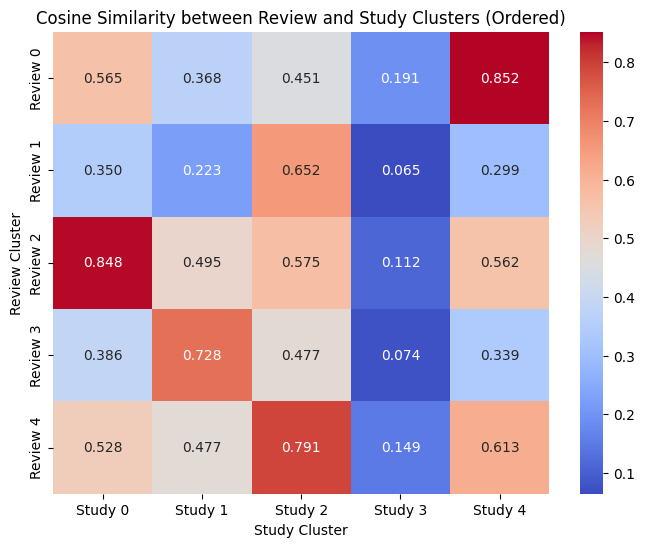

In [141]:
# Combine abstracts for each cluster in the study DataFrame in numerical order
study_clusters = {
    cluster: combine_abstracts(study_df, cluster, 'study_cluster')
    for cluster in sorted(study_df['study_cluster'].unique())
}

# Combine abstracts for each cluster in the review DataFrame in numerical order
review_clusters = {
    cluster: combine_abstracts(review_df, cluster, 'review_cluster')
    for cluster in sorted(review_df['review_cluster'].unique())
}

# Create lists of combined abstracts and labels for study and review clusters separately
study_texts = list(study_clusters.values())
review_texts = list(review_clusters.values())
study_labels = [f"Study {label}" for label in sorted(study_clusters.keys())]
review_labels = [f"Review {label}" for label in sorted(review_clusters.keys())]

# Vectorize the combined abstracts using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
study_tfidf_matrix = vectorizer.fit_transform(study_texts)
review_tfidf_matrix = vectorizer.transform(review_texts)

# Calculate cosine similarity between study clusters and review clusters only
cosine_sim_matrix = cosine_similarity(study_tfidf_matrix, review_tfidf_matrix)

# Convert the cosine similarity matrix to a DataFrame for plotting in sorted order and transpose it
cosine_df = pd.DataFrame(cosine_sim_matrix, index=study_labels, columns=review_labels).T

# Print the cosine similarity values for each cluster pair
print("Cosine Similarity Matrix between Review and Study Clusters (Transposed):")
print(cosine_df)

# Plot a heatmap of the transposed cosine similarity matrix with sorted labels
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_df, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Cosine Similarity between Review and Study Clusters")
plt.xlabel("Study Cluster")
plt.ylabel("Review Cluster")
plt.show()


### Heatmap normalized by study cluster

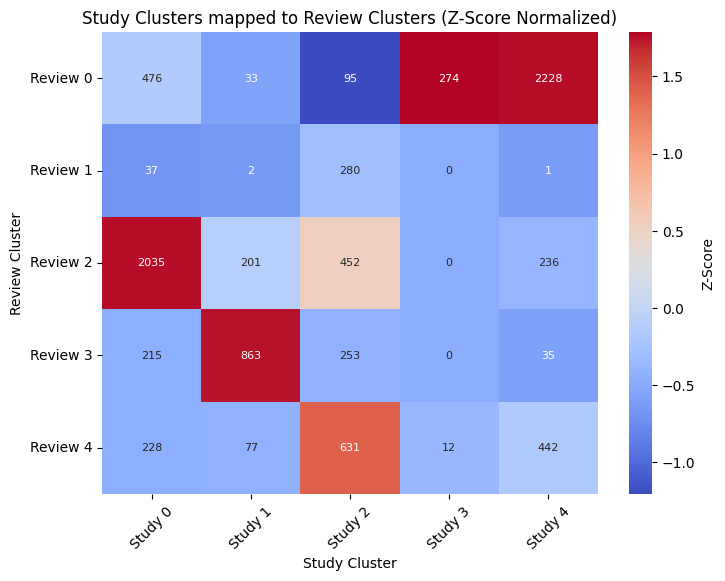

In [138]:
# Concatenate the DataFrames
total_df = pd.concat([review_df, study_df])

# Create a crosstab for review_cluster and study_cluster
heatmap_data_alternate = pd.crosstab(total_df['review_cluster'], total_df['study_cluster'])

# Z-score normalization for the clusters
heatmap_data_alternate_normalized = (heatmap_data_alternate - heatmap_data_alternate.mean()) / heatmap_data_alternate.std()

# Plot the heatmap for Cluster vs alternate_cluster (Z-score Normalized)
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_alternate_normalized, 
    annot=heatmap_data_alternate,  # Display the article count
    fmt="d",  # Format as integer
    annot_kws={'size': 8},  # Control annotation text size
    cmap='coolwarm', 
    cbar_kws={'label': 'Z-Score'}, 
    cbar=True
)

# Labels
plt.title('Study Clusters mapped to Review Clusters (Z-Score Normalized)')
plt.xlabel('Study Cluster')
plt.ylabel('Review Cluster')
plt.xticks(ticks=np.arange(len(heatmap_data_alternate.columns)) + 0.5, 
           labels=[f'Study {i}' for i in range(len(heatmap_data_alternate.columns))], rotation=45)
plt.yticks(ticks=np.arange(len(heatmap_data_alternate.index)) + 0.5, 
           labels=[f'Review {i}' for i in range(len(heatmap_data_alternate.index))], rotation=0)

plt.show()


### Heatmap normalized by review cluster

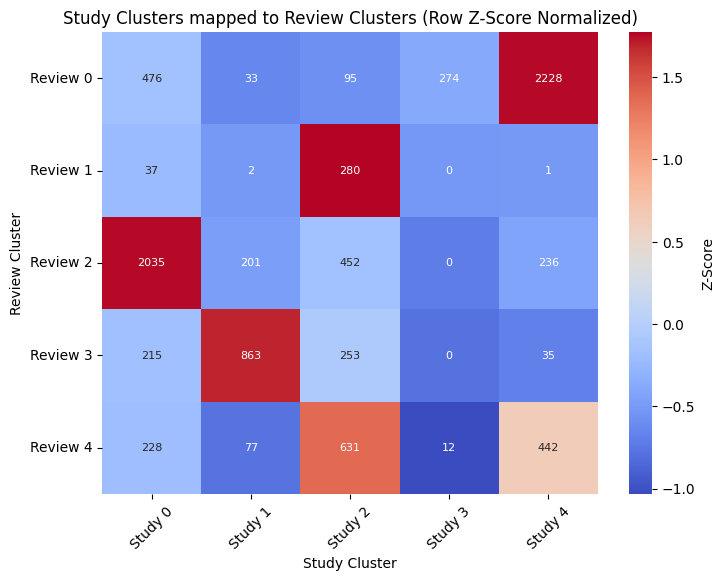

In [139]:
# Concatenate the DataFrames
total_df = pd.concat([review_df, study_df])

# Create a crosstab for review_cluster and study_cluster
heatmap_data_alternate = pd.crosstab(total_df['review_cluster'], total_df['study_cluster'])

# Z-score normalization across each row (axis=1)
heatmap_data_alternate_normalized = heatmap_data_alternate.sub(heatmap_data_alternate.mean(axis=1), axis=0)
heatmap_data_alternate_normalized = heatmap_data_alternate_normalized.div(heatmap_data_alternate.std(axis=1), axis=0)

# Plot the heatmap with normalized values, displaying article counts in each cell
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_alternate_normalized, 
    annot=heatmap_data_alternate,  # Display the article count
    fmt="d",  # Format as integer
    annot_kws={'size': 8},  # Control annotation text size
    cmap='coolwarm', 
    cbar_kws={'label': 'Z-Score'}, 
    cbar=True
)

# Labels
plt.title('Study Clusters mapped to Review Clusters (Row Z-Score Normalized)')
plt.xlabel('Study Cluster')
plt.ylabel('Review Cluster')
plt.xticks(ticks=np.arange(len(heatmap_data_alternate.columns)) + 0.5, 
           labels=[f'Study {i}' for i in range(len(heatmap_data_alternate.columns))], rotation=45)
plt.yticks(ticks=np.arange(len(heatmap_data_alternate.index)) + 0.5, 
           labels=[f'Review {i}' for i in range(len(heatmap_data_alternate.index))], rotation=0)

plt.show()


### Example Heatmap

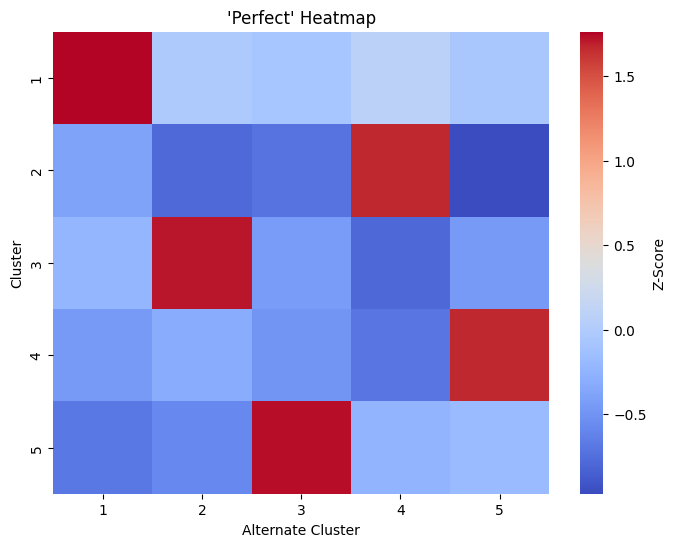

In [143]:
# Example 'perfect' heatmap
data = np.random.randn(5, 5)

# Manually create the "red boxes" by setting higher values for non-diagonal cells
# For example, shift the red boxes off-diagonal
data[0, 0] = 9
data[1, 3] = 5
data[3, 4] = 7
data[2, 1] = 8
data[4, 2] = 7

# Create a DataFrame for the heatmap data, now labeled simply 1-5 for columns and rows
heatmap_data_alternate = pd.DataFrame(data, columns=[i for i in range(1, 6)], 
                                      index=[i for i in range(1, 6)])

# Z-score normalization
heatmap_data_alternate_normalized = (heatmap_data_alternate - heatmap_data_alternate.mean()) / heatmap_data_alternate.std()

# Plot the heatmap with the prominent red boxes
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_alternate_normalized, annot=False, cmap='coolwarm', cbar_kws={'label': 'Z-Score'}, cbar=True)
plt.title("'Perfect' Heatmap")
plt.xlabel('Alternate Cluster')
plt.ylabel('Cluster')
plt.show()